### Importation des modules

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pydotplus
from random import *
from tqdm import tqdm
import os

### Importation des deux datashets 'train' et 'test' depuis la librairie tensorflow_datasets

In [2]:
train_ds,test_ds = tfds.load('svhn_cropped', split=['train','test'], shuffle_files=True)
nb_train_max=len(train_ds)
nb_test_max=len(test_ds)
print(nb_train_max,nb_test_max)

73257 26032


In [3]:
train_images_color=[]
train_targets=[]
test_images_color=[]
test_targets=[]

Création de listes pour faciliter le traitement après

In [4]:
nb_train=80000
i=0
for example in train_ds:
    train_images_color.append(example['image'])
    train_targets.append(example['label'])
    i+=1
    if i==nb_train:
        break

In [5]:
nb_test=30000
i=0
for example in test_ds:
    test_images_color.append(example['image'])
    test_targets.append(example['label'])
    i+=1
    if i==nb_test:
        break

In [6]:
train_images_color=np.array(train_images_color)
train_targets=np.array(train_targets)
test_images_color=np.array(test_images_color)
test_targets=np.array(test_targets)

On peut voir le nombre d'images pour chacune des listes ainsi que la dimmension des images

In [7]:
print(train_images_color.shape,train_targets.shape)
print(test_images_color.shape,test_targets.shape)


(73257, 32, 32, 3) (73257,)
(26032, 32, 32, 3) (26032,)


Quelques exemples d'images avec le label associé

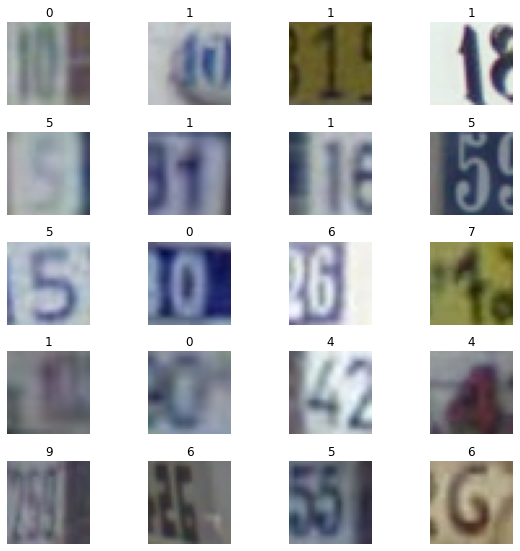

In [8]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
batch=[]
for i in range(1, columns*rows +1):
    index = np.random.randint(len(train_images_color))
    img = train_images_color[index]
    batch.append(index)
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.title(train_targets[index]) 
    plt.axis('off')
    plt.imshow(img)
plt.show()

### Répartition des classes

In [9]:
repartition_train=np.zeros((10))
for i in range(len(train_targets)):
    repartition_train[train_targets[i]]+=1
               
print(repartition_train)

[ 4948. 13861. 10585.  8497.  7458.  6882.  5727.  5595.  5045.  4659.]


<BarContainer object of 10 artists>

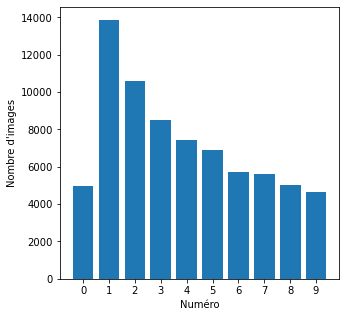

In [10]:
fig=plt.figure(figsize=(5, 5))
ax=fig.add_subplot(111)
ax.set_xlabel('Numéro')
ax.set_ylabel("Nombre d'images")
ax.set_xticks(np.linspace(0,9,10))
ax.bar(np.linspace(0,9,10), repartition_train)

In [11]:
repartition_test=np.zeros((10))
for i in range(len(test_targets)):
    repartition_test[train_targets[i]]+=1
               
print(repartition_test)

[1756. 4888. 3660. 3090. 2732. 2433. 1979. 2011. 1822. 1661.]


<BarContainer object of 10 artists>

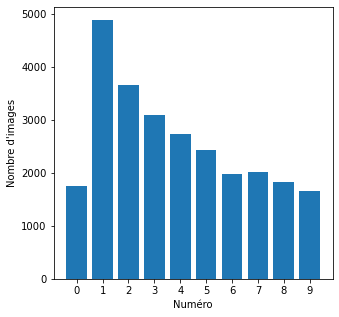

In [12]:
fig=plt.figure(figsize=(5, 5))
ax=fig.add_subplot(111)
ax.set_xlabel('Numéro')
ax.set_ylabel("Nombre d'images")
ax.set_xticks(np.linspace(0,9,10))
ax.bar(np.linspace(0,9,10), repartition_test)

# Traitement des images  
## Rendu en niveau de gris
Sachant que le niveau de gris vaut: Y = 0.2125 R + 0.7154 G + 0.0721 B

In [13]:
train_images=np.zeros((train_images_color.shape[0:3]))
test_images=np.zeros((test_images_color.shape[0:3]))

Conversion en niveau de gris

In [14]:
for i in range (train_images.shape[0]):
    train_images[i]=0.2125*train_images_color[i,:,:,0] + 0.7154*train_images_color[i,:,:,1] + 0.0721*train_images_color[i,:,:,2]

for i in range (test_images.shape[0]):
    test_images[i]=0.2125*test_images_color[i,:,:,0] + 0.7154*test_images_color[i,:,:,1] + 0.0721*test_images_color[i,:,:,2]
    

### Affichage des images en niveau de gris

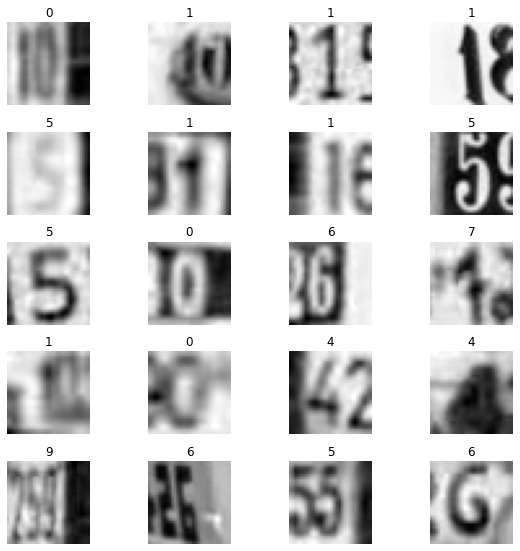

In [15]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img = train_images[batch[i-1]]
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.title(train_targets[batch[i-1]]) 
    plt.axis('off')
    plt.imshow(img,cmap='gray')
plt.show()

On a bien converti les images en noir et blanc

In [16]:
train_images.shape

(73257, 32, 32)

In [17]:
train_images[0]

array([[65.2125, 72.7154, 76.7875, ..., 62.7344, 75.7344, 90.0931],
       [68.0721, 73.7875, 78.7875, ..., 66.2373, 81.5902, 94.0931],
       [71.3567, 76.9317, 82.2163, ..., 74.0248, 90.0248, 96.0931],
       ...,
       [90.1404, 90.3529, 91.4971, ..., 16.4724, 14.6887, 14.332 ],
       [92.425 , 92.425 , 93.2125, ..., 12.8936, 12.5369, 17.2523],
       [93.2125, 93.0683, 92.425 , ..., 23.8938, 26.0304, 35.1708]])

## Normalisation
Maintenant, il faut normaliser les données avant de les injecter dans le modèle.   
### Calcul de la moyenne des valeurs des pixels et de l'écart type

In [18]:
train_mean=train_images.mean()
train_std=train_images.std()
print(train_mean)
print(train_std)
test_mean=test_images.mean()
test_std=test_images.std()


113.36522064289996
50.534126548394475


### Normalisation
On applique z = $\frac{x - mean}{std}$  pour normaliser nos données

In [19]:
for i in range (train_images.shape[0]):
    train_images[i]=(train_images[i]-train_mean)/train_std

for i in range (test_images.shape[0]):
    test_images[i]=(test_images[i]-test_mean)/test_std

In [20]:
print(train_images.mean())
print(train_images.std())

-2.1201589185733363e-15
1.0000000000000022


### Affichage du tableau correspondant à une image normalisée

In [21]:
train_images[0]

array([[-0.95287529, -0.80440335, -0.72382216, ..., -1.00191344,
        -0.74466154, -0.46052286],
       [-0.89628779, -0.78318798, -0.68424495, ..., -0.93259593,
        -0.62878341, -0.38136843],
       [-0.83129013, -0.72096864, -0.61639377, ..., -0.77849215,
        -0.46187443, -0.34179122],
       ...,
       [-0.45958686, -0.45538178, -0.43273966, ..., -1.91737401,
        -1.95267095, -1.95972954],
       [-0.41437781, -0.41437781, -0.39879428, ..., -1.98819347,
        -1.99525207, -1.90194087],
       [-0.39879428, -0.4016478 , -0.41437781, ..., -1.77051483,
        -1.72823449, -1.54735871]])

### Création d'objets TensorFlow pour gérer plus facilement les données

In [22]:
train_images = train_images.reshape(-1, 32, 32, 1)
test_images = test_images.reshape(-1, 32, 32, 1)
print(train_images.shape)


entrainement_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_targets))
validation_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_targets))

(73257, 32, 32, 1)


# Modèle
Maintenant qu'on a nos données normalisées, on peut créer notre modèle
## Structure du modèle

In [23]:
model = tf.keras.models.Sequential()

#Premiere convolution
model.add( tf.keras.layers.Conv2D(32, 4, padding='same', activation='relu', name="conv1"))
model.add( tf.keras.layers.MaxPool2D((2,2)))
model.add( tf.keras.layers.Dropout(rate=0.1))

#Deuxieme convolution
model.add( tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', name="conv2"))
model.add( tf.keras.layers.MaxPool2D((2,2)))
model.add( tf.keras.layers.Dropout(rate=0.2))

#Troisieme convolution
model.add( tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', name="conv3"))
model.add( tf.keras.layers.MaxPool2D((2,2)))
model.add( tf.keras.layers.Dropout(rate=0.3))

# Mise sous forme d'un vecteur
model.add( tf.keras.layers.Flatten(name="flatten"))

# Ajout d'une couche de reseau de neurone
model.add( tf.keras.layers.Dense(512, activation='relu', name="d1"))
model.add( tf.keras.layers.Dropout(rate=0.5))

#Ajout d'une couche de 10 neurones correspondant aux 10 chiffres à détecter
model.add( tf.keras.layers.Dense(10, activation='softmax', name="output"))

In [24]:
# model.summary()

## Fonction d'erreur et optimiseur

In [25]:
fonction_erreur = tf.keras.losses.SparseCategoricalCrossentropy()
optimiseur = tf.keras.optimizers.Adam(learning_rate=0.001)

In [26]:
# Erreur
erreur_entrainement_totale = tf.keras.metrics.Mean(name='train_loss')
erreur_validation_totale = tf.keras.metrics.Mean(name='valid_loss')
# Precision
precision_entrainement_totale = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
precision_validation_totale = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [27]:
@tf.function
def predict(image):
    prediction=model(image)
    return prediction

# Entrainement
## Fonction d'entrainement

In [28]:
@tf.function #décorateur de fonction qui transforme le modèle en graphe pour des calculs plus rapides
def entrainement(image, targets):
    with tf.GradientTape() as tape:
        # Prediction sur le batch
        predictions = model(image,training=True)
        # Calcul de l'erreur
        erreur = fonction_erreur(targets, predictions)
        
    # Calcul du gradient pour réduire l'erreur
    gradients = tape.gradient(erreur, model.trainable_variables)
    
    # Optimisation des poids du modèle
    optimiseur.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Mise à jour des variables de suivi de l'entrainement
    erreur_entrainement_totale(erreur)
    precision_entrainement_totale(targets, predictions)

## Fonction de validation

In [29]:
@tf.function
def validation(image, targets):
    predictions = model(image,training=False)
    erreur_validation = fonction_erreur(targets, predictions)
    # Mise à jour des variables de suivi de la validation
    erreur_validation_totale(erreur_validation)
    precision_validation_totale(targets, predictions)
    return predictions

## Lancement de l'entrainement

In [30]:
nombre_entrainements=5
taille_batch=32

for i in range(nombre_entrainements):
    b=0
    print('Epochs:',i+1)
    batch = entrainement_dataset.batch(taille_batch)
    for images, targets in batch:
        entrainement(images,targets)
        b+=taille_batch
    print(f'Entrainement :{erreur_entrainement_totale.result()} et precision ={precision_entrainement_totale.result()*100}')
    batch = validation_dataset.batch(taille_batch*10)
    for images, targets in batch:
        validation(images,targets)  
    print(f'Validation : erreur={erreur_validation_totale.result()} et precision = {precision_validation_totale.result()*100}')
    
    erreur_entrainement_totale.reset_states()
    precision_entrainement_totale.reset_states()
    erreur_validation_totale.reset_states()
    precision_validation_totale.reset_states()

Epochs: 1
Entrainement :0.7787309885025024 et precision =75.01399230957031
Validation : erreur=0.4327436685562134 et precision = 87.38475799560547


## Sauvegarde/chargement  du modèle

In [31]:
#Sauvegarde du modèle
# model.save('svnh')

#Chargement d'un modèle
# model=tf.keras.models.load_model('svnh2')

#JSON
# json_config = model.to_json()
# print(json_config)

# Résultats

In [32]:
@tf.function
def call(model,image):
    prediction=model(image,training=False)
    return prediction

In [33]:
echec=[]
echec_numeros=np.zeros((10,10))
for i in tqdm(range(len(test_targets))):
    prediction=call(model,test_images[i].reshape((1,32,32,1))).numpy()
    numero_predit=np.argmax(prediction)
    if numero_predit!=test_targets[i]:
        echec.append([test_targets[i],test_images_color[i],prediction])
        echec_numeros[test_targets[i],numero_predit]+=1
print(f'Precision={100*(1-len(echec)/len(test_targets))}')

100%|███████████████████████████████████████████████████████████████████████████| 26032/26032 [00:56<00:00, 463.57it/s]

Precision=93.24293177627536


## Nombre d'erreur par numéros

<BarContainer object of 10 artists>

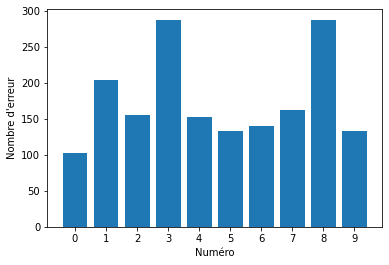

In [34]:
echec_numeros_bis=np.sum(echec_numeros,axis=1)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_xlabel('Numéro')
ax.set_ylabel("Nombre d'erreur")
ax.set_xticks(np.linspace(0,9,10))
ax.bar(np.linspace(0,9,10), echec_numeros_bis)

## Pourcentage d'erreur par numéros

<BarContainer object of 10 artists>

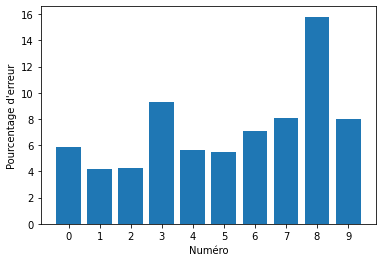

In [35]:
echec_numeros_pourcentage=np.zeros(10)
for i in range(10):
    echec_numeros_pourcentage[i]=100*echec_numeros_bis[i]/repartition_test[i]
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_xlabel('Numéro')
ax.set_ylabel("Pourcentage d'erreur")
ax.set_xticks(np.linspace(0,9,10))
ax.bar(np.linspace(0,9,10), echec_numeros_pourcentage)

## Répartition des numéros prédits par numéro

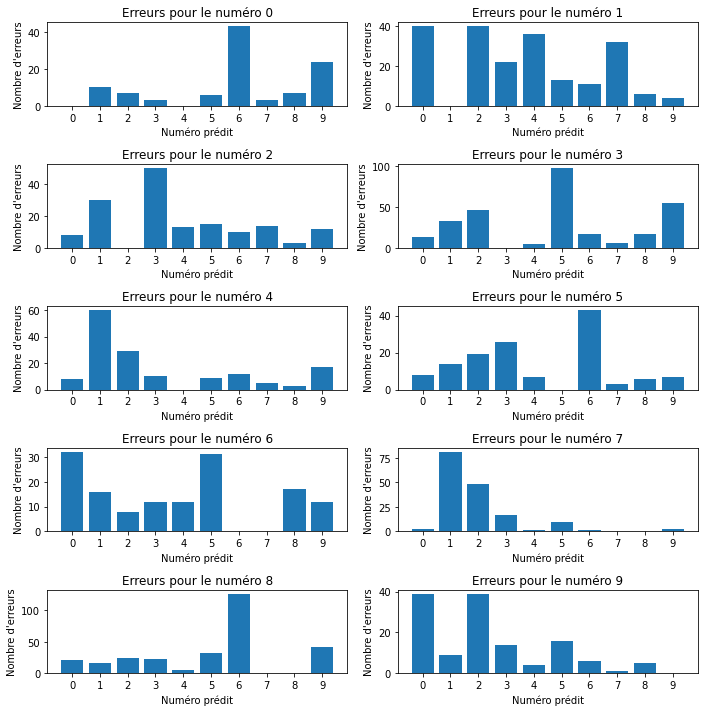

In [36]:
fig=plt.figure(figsize=(10,10))

for i in range(10):
    ax=fig.add_subplot(5,2,i+1)
    fig.tight_layout()
    ax.set_xlabel('Numéro prédit')
    ax.set_ylabel("Nombre d'erreurs")
    ax.set_xticks(np.linspace(0,9,10))
    ax.set_title(f'Erreurs pour le numéro {i}')
    ax.bar(np.linspace(0,9,10), echec_numeros[i])

On remarque que les erreurs sont souvent faites avec des nuéros assez ressemblants.

## Affichage des valeurs prédites pour quelques erreurs

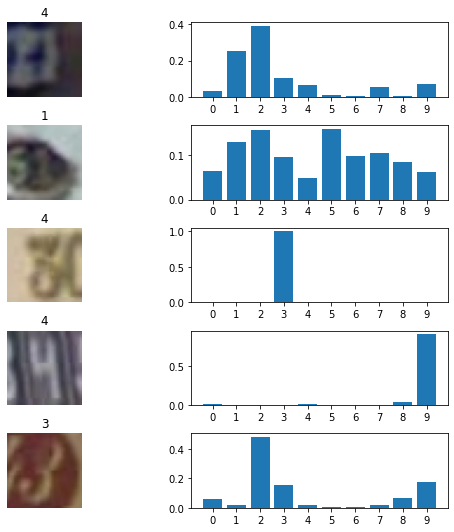

In [37]:
nb_erreurs_affichees=5
fig=plt.figure(figsize=(8,nb_erreurs_affichees*1.5))
for i in range(nb_erreurs_affichees):
    index_erreurs = np.random.randint(len(echec))
    ax=fig.add_subplot(nb_erreurs_affichees,2,2*i+1)
    fig.tight_layout()
    ax.imshow(echec[index_erreurs][1])
    ax.set_title(str(echec[index_erreurs][0]))
    ax.axis('off')
    ax=fig.add_subplot(nb_erreurs_affichees,2,2*(i+1))
    ax.set_xticks(np.linspace(0,9,10))
    ax.bar(np.linspace(0,9,10), echec[index_erreurs][2][0])
    

Les erreurs sont parfois pour des numéros très difficilement lisible ou des numéros très ressemblants. 
Et souvent le bon numéros est la deuxième prédiction donc le modèle est assez précis.